In [5]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import lime
import lime.lime_tabular

In [6]:
file_path = "heart.csv"
df = pd.read_csv(file_path)

X = df.drop(columns='target')
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. Preprocessing Pipeline

In [7]:
# Define numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler())])  # Scale numerical features

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # One-hot encode categorical features

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply preprocessing to the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


### 2. Ensemble Learning

In [8]:
# -------------------------------
# 1️⃣ Bagging Ensemble with Decision Trees
# -------------------------------
num_models = 5
sample_size = 800
np.random.seed(0)

bagging_models = []
for m in range(num_models):
    sample_idx = np.random.choice(X_train_preprocessed.shape[0], sample_size, replace=True)
    X_train_sample, y_train_sample = X_train_preprocessed[sample_idx], y_train.iloc[sample_idx]
    model = DecisionTreeClassifier(max_features=4)
    model.fit(X_train_sample, y_train_sample)
    bagging_models.append(model)

# Bagging Prediction Function
def bagging_predict(test_data, models):
    votes = np.zeros((test_data.shape[0], len(models)))
    for idx, m in enumerate(models):
        votes[:, idx] = m.predict(test_data)
    return np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=votes)

# Evaluate Bagging Model
bagging_preds = bagging_predict(X_test_preprocessed, bagging_models)
bagging_acc = np.mean(bagging_preds == y_test) * 100
print("Bagging Test Accuracy: {:.2f}%".format(bagging_acc))

Bagging Test Accuracy: 97.07%


In [9]:
# -------------------------------
# 2️⃣ Boosting with AdaBoost 
# -------------------------------
boosting_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=0)
boosting_model.fit(X_train_preprocessed, y_train)

# Predictions and accuracy
boosting_preds = boosting_model.predict(X_test_preprocessed)
boosting_acc = np.mean(boosting_preds == y_test) * 100
print("Boosting Test Accuracy: {:.2f}%".format(boosting_acc))


Boosting Test Accuracy: 98.54%


In [10]:
# -------------------------------
# 3️⃣ Random Forest Model
# -------------------------------
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf_model.fit(X_train_preprocessed, y_train)

# Predictions and accuracy
rf_preds = rf_model.predict(X_test_preprocessed)
rf_acc = np.mean(rf_preds == y_test) * 100
print("Random Forest Test Accuracy: {:.2f}%".format(rf_acc))

Random Forest Test Accuracy: 85.37%


### 3. Shap

  0%|          | 0/205 [00:00<?, ?it/s]

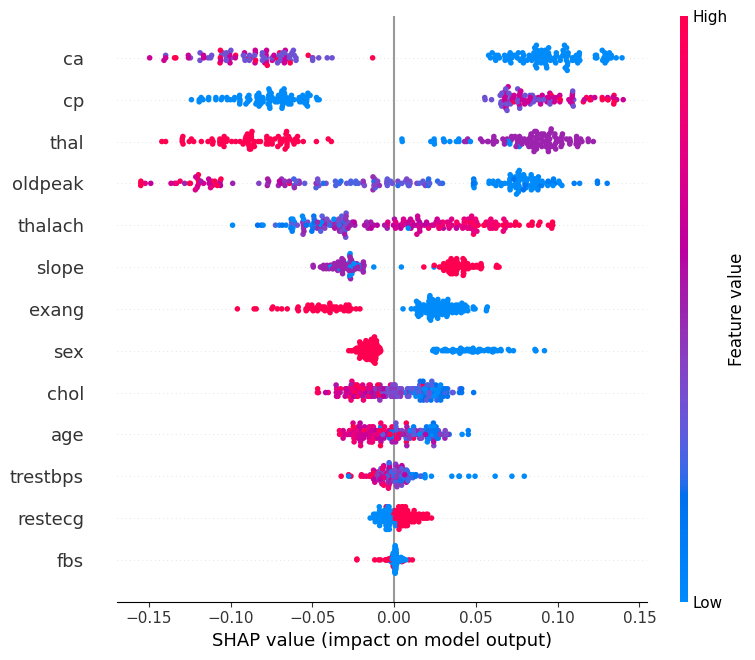

In [11]:
# Define a prediction function for the model
def predict_fn(X):
    # Ensure the input is a 2D array
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    # Convert input to a DataFrame with the correct feature names
    X_df = pd.DataFrame(X, columns=X_train.columns)
    # Preprocess the input data
    X_preprocessed = preprocessor.transform(X_df)
    # Make predictions using the Random Forest model
    return rf_model.predict_proba(X_preprocessed)[:, 1]  # Use probability for class 1 (positive class)

# Create a summary dataset (background for SHAP)
# Use a subset of the training data (e.g., 50 samples)
X_train_summary = shap.sample(X_train, 50)

# Convert X_train_summary to a DataFrame with feature names
X_train_summary_df = pd.DataFrame(X_train_summary, columns=X_train.columns)

# Initialize SHAP KernelExplainer
shap.initjs()
ex = shap.KernelExplainer(predict_fn, X_train_summary_df)

# Ensure X_test is a DataFrame with feature names
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Compute SHAP values for a single instance
shap_values_single = ex.shap_values(X_test_df.iloc[1, :])

# Generate a force plot for the single instance
shap.force_plot(ex.expected_value, shap_values_single, X_test_df.iloc[1, :])

# Compute SHAP values for the entire test set
shap_values = ex.shap_values(X_test_df)

# Generate a summary plot for global feature importance
shap.summary_plot(shap_values, X_test_df)

### 4. LIME

In [12]:

# Define a prediction function for the model
def predict_fn(X):
    # Ensure the input is a 2D array
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    # Convert input to a DataFrame with the correct feature names
    X_df = pd.DataFrame(X, columns=X_train.columns)
    # Preprocess the input data
    X_preprocessed = preprocessor.transform(X_df)
    # Make predictions using the Random Forest model
    return rf_model.predict_proba(X_preprocessed)  # Return probabilities for all classes

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,  # Use the training data
    feature_names=X_train.columns.tolist(),  # Provide feature names
    class_names=['No Heart Disease', 'Heart Disease'],  # Class names for binary classification
    mode='classification'  # Set mode to classification
)

# Explain a single instance (e.g., the first instance in the test set)
instance_index = 0  # Index of the instance to explain
exp = explainer.explain_instance(
    data_row=X_test.iloc[instance_index, :].values,  # Instance to explain
    predict_fn=predict_fn,  # Prediction function
    num_features=10  # Number of features to include in the explanation
)

# Visualize the explanation
exp.show_in_notebook()

In [13]:
instance_index = 1  # Index of the instance to explain
exp = explainer.explain_instance(
    data_row=X_test.iloc[instance_index, :].values,  # Instance to explain
    predict_fn=predict_fn,  # Prediction function
    num_features=10  # Number of features to include in the explanation
)

# Visualize the explanation
exp.show_in_notebook()

In [14]:
instance_index = 2  # Index of the instance to explain
exp = explainer.explain_instance(
    data_row=X_test.iloc[instance_index, :].values,  # Instance to explain
    predict_fn=predict_fn,  # Prediction function
    num_features=10  # Number of features to include in the explanation
)

# Visualize the explanation
exp.show_in_notebook()